In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

# Problem1

## 1. Text Data Preprocessing

### 1.1 Load the Text Data

In [2]:
df = pd.read_csv("bbc-text.csv")

In [3]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


<AxesSubplot:>

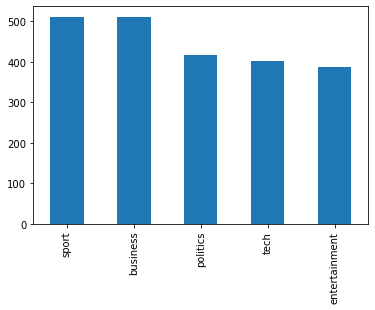

In [5]:
df.category.value_counts().plot.bar()

### 1.2 Cleanse the Text Data

In [6]:
df.text[0][:100]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital'

In [7]:
def get_stop_words(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)

def preprocessor(word):
    return re.sub("(\\d|\\W|_)+"," ",word)

wn = nltk.WordNetLemmatizer()

def LemmaTokenizer(text):
    tokens = re.split('\\W+', text)
    return [wn.lemmatize(word) for word in tokens if word not in stopwords]

#load a set of stop words
stopwords=get_stop_words("stopwords.txt")

In [8]:
[i for i in LemmaTokenizer(preprocessor(df.text[0][:100]))]

['tv',
 'future',
 'hand',
 'viewer',
 'home',
 'theatre',
 'system',
 'plasma',
 'definition',
 'tv',
 'digital']

### 1.3 Bag-of-Word

In [9]:
count_vect = CountVectorizer(max_df=0.15, max_features=5000, lowercase=True, 
                             preprocessor=preprocessor, tokenizer=LemmaTokenizer)
X_counts = count_vect.fit_transform(df.text)

In [10]:
pd.DataFrame(X_counts.toarray(), columns=count_vect.get_feature_names_out())

,aaa,abandoned,abbott,abc,ability,able,abn,abortion,abroad,absence,...,yuan,yugansk,yuganskneftegas,yukos,yushchenko,zealand,zero,zombie,zone,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2221,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.4 TF-IDF

In [11]:
tfidf_transformer=TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [12]:
tfidf_transformer.idf_

array([5.93537281, 5.81758977, 6.40537644, ..., 6.40537644, 5.66343909,
       5.99991133])

In [13]:
pd.DataFrame(X_tfidf.toarray(), columns=count_vect.get_feature_names_out())

,aaa,abandoned,abbott,abc,ability,able,abn,abortion,abroad,absence,...,yuan,yugansk,yuganskneftegas,yukos,yushchenko,zealand,zero,zombie,zone,zurich
0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.04595,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2221,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.090557,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2222,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2223,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Text Data Understanding

### 2.1 Extract keywords using TF-IDF matrix

In [14]:
# find maximum value for each of the features over dataset:
max_value = X_tfidf.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

highestTfidf = np.array(count_vect.get_feature_names_out())[sorted_by_tfidf[-500:]]
highestTfidf


array(['oil', 'csa', 'india', 'adult', 'robinson', 'tindall', 'ethnic',
       'blake', 'price', 'bonus', 'singapore', 'worm', 'prisoner', 'band',
       'visual', 'thanou', 'bob', 'mayor', 'text', 'message', 'gun',
       'coast', 'pipeline', 'circuit', 'blair', 'wood', 'mock', 'balco',
       'un', 'lindsay', 'saudi', 'bn', 'houston', 'marvel', 'bekele',
       'broadway', 'sale', 'howard', 'budget', 'robertson', 'rate',
       'series', 'jam', 'ericsson', 'donofrio', 'billboard', 'carpenter',
       'cebit', 'plasma', 'worldcom', 'brown', 'currency', 'election',
       'tree', 'asimo', 'nielsen', 'gold', 'mail', 'embargo', 'neeson',
       'jay', 'federer', 'right', 'kerr', 'newton', 'beckham', 'wright',
       'pound', 'fightstar', 'xstrata', 'airway', 'bittorrent', 'buyer',
       'marathon', 'brazil', 'moment', 'site', 'peel', 'tax', 'egypt',
       'studio', 'beattie', 'tate', 'vieira', 'ghosn', 'presenter',
       'boateng', 'boerse', 'chepkemei', 'jamelia', 'allied', 'enron',


In [15]:
def extract_keywords(paragraph):
    paragraph = LemmaTokenizer(preprocessor(paragraph.lower()))
    keywords = [word for word in paragraph if word in highestTfidf and word not in stopwords]
    return keywords

In [16]:
cleaned_array = df.text.apply(lambda x: extract_keywords(x))
cleaned_array

0       [theatre, plasma, digital, telecom, broadband,...
1       [worldcom, worldcom, ebbers, bn, bn, fraud, eb...
2       [farrell, farrell, rugby, moment, farrell, far...
3       [arsenal, chelsea, everton, sunderland, bolton...
4       [chart, ticket, sale, studio, hank, christmas,...
                              ...                        
2220    [sale, sale, sale, sale, christmas, sale, sale...
2221    [kilroy, kilroy, wage, party, asylum, bn, kilr...
2222    [band, scottish, band, ticket, bank, scottish,...
2223    [blair, brown, child, adult, blair, brown, pri...
2224    [souness, souness, uefa, uefa, job, souness, s...
Name: text, Length: 2225, dtype: object

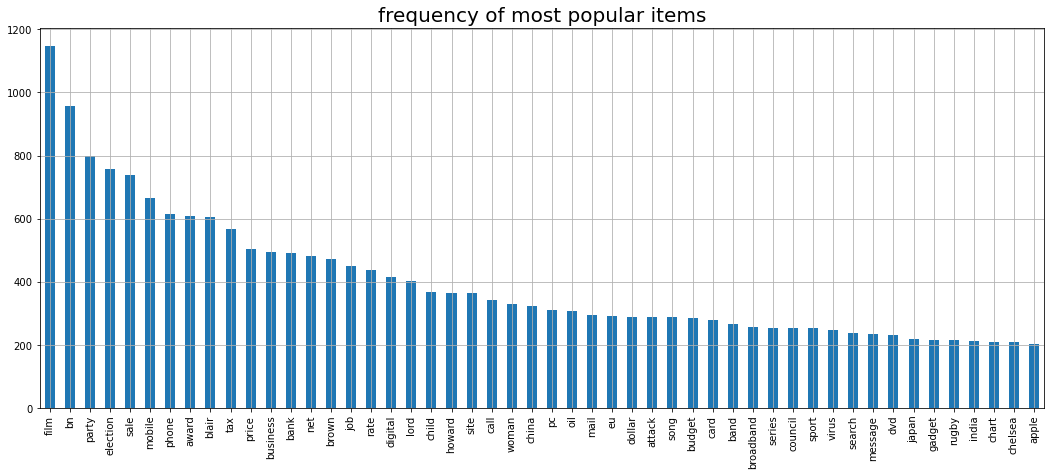

In [17]:
full_list = []
for row in cleaned_array:
    for value in row:
        full_list.append(value)
    
full_list = pd.Series(full_list)    

# looking at the frequency of most popular items 
plt.figure(figsize=(18,7))
full_list.value_counts().head(50).plot.bar()
plt.title('frequency of most popular items', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

In [18]:
te = TransactionEncoder()
data_encoded = te.fit_transform(cleaned_array)
data_encoded = pd.DataFrame(data_encoded, columns = te.columns_)
data_encoded

,abortion,ac,adoption,adult,agassi,age,ahold,airline,airway,allied,...,wood,worldcom,worm,wright,wto,xbox,xstrata,yahoo,yukos,zealand
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2221,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2222,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2223,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### 2.2 Association Rules Mining on keywords

In [19]:
frequent_itemsets=apriori(data_encoded, min_support = 0.01, use_colnames = True)
frequent_itemsets.sort_values("support", ascending = False, inplace=True)
frequent_itemsets.head(10)

,support,itemsets
18,0.147865,(bn)
117,0.146966,(sale)
26,0.139326,(business)
62,0.126292,(film)
101,0.121798,(party)
111,0.105618,(price)
82,0.103820,(job)
58,0.102921,(election)
28,0.089888,(call)
99,0.088989,(net)


In [20]:
frequent_itemsets[['support']].describe()

,support
count,451.000000
mean,0.022379
std,0.020103
min,0.010337
25%,0.012135
50%,0.015281
75%,0.023146
max,0.147865


In [21]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)
rules.sort_values("lift", ascending=False, inplace=True)
rules = rules[rules.confidence > 0.5]
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))

# rules["consequents_len"] = rules["consequents"].apply(lambda x: len(x))
# rules = rules[rules.consequents_len == 1]

rules.head(15)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
772,(yukos),"(bn, tax, oil)",0.012135,0.015281,0.010337,0.851852,55.746187,0.010152,6.646854,1
761,"(bn, tax, oil)",(yukos),0.015281,0.012135,0.010337,0.676471,55.746187,0.010152,3.053401,3
765,"(bn, yukos)","(tax, oil)",0.011685,0.017079,0.010337,0.884615,51.796559,0.010138,8.518652,2
768,"(tax, oil)","(bn, yukos)",0.017079,0.011685,0.010337,0.605263,51.796559,0.010138,2.503730,2
784,(yukos),"(tax, oil)",0.012135,0.017079,0.010337,0.851852,49.878168,0.010130,6.634719,1
781,"(tax, oil)",(yukos),0.017079,0.012135,0.010337,0.605263,49.878168,0.010130,2.502592,2
769,"(yukos, tax)","(bn, oil)",0.010787,0.024270,0.010337,0.958333,39.486883,0.010075,23.417528,2
638,(yukos),"(bn, oil)",0.012135,0.024270,0.011236,0.925926,38.151578,0.010941,13.172360,1
395,(google),(search),0.016629,0.027416,0.013483,0.810811,29.574657,0.013027,5.140803,1
690,(yukos),"(bn, tax)",0.012135,0.041798,0.010787,0.888889,21.266428,0.010279,8.623820,1


<AxesSubplot:>

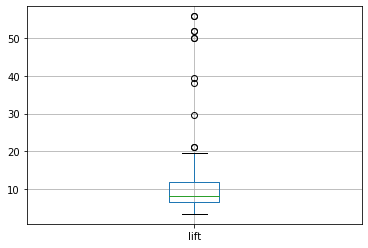

In [22]:
rules[['lift']].boxplot()

In [23]:
rules[rules.antecedent_len == 1].head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
772,(yukos),"(bn, tax, oil)",0.012135,0.015281,0.010337,0.851852,55.746187,0.010152,6.646854,1
784,(yukos),"(tax, oil)",0.012135,0.017079,0.010337,0.851852,49.878168,0.010130,6.634719,1
638,(yukos),"(bn, oil)",0.012135,0.024270,0.011236,0.925926,38.151578,0.010941,13.172360,1
395,(google),(search),0.016629,0.027416,0.013483,0.810811,29.574657,0.013027,5.140803,1
690,(yukos),"(bn, tax)",0.012135,0.041798,0.010787,0.888889,21.266428,0.010279,8.623820,1
546,(yukos),(oil),0.012135,0.048989,0.011685,0.962963,19.656813,0.011091,25.677303,1
322,(gas),(oil),0.016180,0.048989,0.014382,0.888889,18.144750,0.013589,8.559101,1
442,(arsenal),(chelsea),0.024719,0.031011,0.012584,0.509091,16.416337,0.011818,1.973866,1
792,(zealand),(rugby),0.018876,0.034607,0.010337,0.547619,15.824057,0.009684,2.134027,1
384,(currency),(dollar),0.017079,0.058876,0.013483,0.789474,13.409000,0.012478,4.470337,1


In [24]:
rules[rules.antecedent_len == 2].head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
765,"(bn, yukos)","(tax, oil)",0.011685,0.017079,0.010337,0.884615,51.796559,0.010138,8.518652,2
768,"(tax, oil)","(bn, yukos)",0.017079,0.011685,0.010337,0.605263,51.796559,0.010138,2.503730,2
781,"(tax, oil)",(yukos),0.017079,0.012135,0.010337,0.605263,49.878168,0.010130,2.502592,2
769,"(yukos, tax)","(bn, oil)",0.010787,0.024270,0.010337,0.958333,39.486883,0.010075,23.417528,2
767,"(yukos, oil)","(bn, tax)",0.011685,0.041798,0.010337,0.884615,21.164185,0.009849,8.304419,2
634,"(bn, yukos)",(oil),0.011685,0.048989,0.011236,0.961538,19.627735,0.010664,24.726292,2
782,"(yukos, tax)",(oil),0.010787,0.048989,0.010337,0.958333,19.562309,0.009809,22.824270,2
775,"(gadget, phone)",(mobile),0.011236,0.056180,0.010337,0.920000,16.376000,0.009706,11.797753,2
615,"(camera, phone)",(mobile),0.012584,0.056180,0.011236,0.892857,15.892857,0.010529,8.808989,2
733,"(phone, text)",(mobile),0.012135,0.056180,0.010787,0.888889,15.822222,0.010105,8.494382,2


In [25]:
rules[rules.antecedent_len == 3].head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
761,"(bn, tax, oil)",(yukos),0.015281,0.012135,0.010337,0.676471,55.746187,0.010152,3.053401,3
762,"(bn, yukos, tax)",(oil),0.010787,0.048989,0.010337,0.958333,19.562309,0.009809,22.824270,3
760,"(bn, yukos, oil)",(tax),0.011236,0.073708,0.010337,0.920000,12.481707,0.009509,11.578652,3
191,"(blair, brown, party)",(election),0.017978,0.102921,0.017528,0.975000,9.473253,0.015678,35.883146,3
190,"(election, brown, party)",(blair),0.023371,0.080899,0.017528,0.750000,9.270833,0.015637,3.676404,3
623,"(tax, brown, party)",(election),0.012135,0.102921,0.011236,0.925926,8.996442,0.009987,12.110562,3
454,"(election, tax, party)",(howard),0.023820,0.062472,0.012135,0.509434,8.154608,0.010647,1.911115,3
535,"(blair, tax, party)",(election),0.014382,0.102921,0.011685,0.812500,7.894378,0.010205,4.784419,3
216,"(election, howard, party)",(blair),0.026067,0.080899,0.016629,0.637931,7.885536,0.014520,2.538470,3
455,"(party, howard, tax)",(election),0.015281,0.102921,0.012135,0.794118,7.715772,0.010562,4.357239,3


In [26]:
rules[rules['consequents'] == {'film'}]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
269,(theatre),(film),0.021124,0.126292,0.015281,0.723404,5.728023,0.012613,3.158790,1
278,(festival),(film),0.021124,0.126292,0.015281,0.723404,5.728023,0.012613,3.158790,1
72,(studio),(film),0.034607,0.126292,0.024270,0.701299,5.552988,0.019899,2.925022,1
232,(dvd),(film),0.026067,0.126292,0.016629,0.637931,5.051233,0.013337,2.413098,1
9,(award),(film),0.081348,0.126292,0.044494,0.546961,4.330922,0.034221,1.928550,1


In [27]:
rules[rules['antecedents'] == {'yukos'}]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
772,(yukos),"(bn, tax, oil)",0.012135,0.015281,0.010337,0.851852,55.746187,0.010152,6.646854,1
784,(yukos),"(tax, oil)",0.012135,0.017079,0.010337,0.851852,49.878168,0.010130,6.634719,1
638,(yukos),"(bn, oil)",0.012135,0.024270,0.011236,0.925926,38.151578,0.010941,13.172360,1
690,(yukos),"(bn, tax)",0.012135,0.041798,0.010787,0.888889,21.266428,0.010279,8.623820,1
546,(yukos),(oil),0.012135,0.048989,0.011685,0.962963,19.656813,0.011091,25.677303,1
744,(yukos),(tax),0.012135,0.073708,0.010787,0.888889,12.059621,0.009892,8.336629,1
549,(yukos),(bn),0.012135,0.147865,0.011685,0.962963,6.512439,0.009891,23.007640,1


In [28]:
rules[rules['antecedents'] == {'arsenal'}]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
442,(arsenal),(chelsea),0.024719,0.031011,0.012584,0.509091,16.416337,0.011818,1.973866,1


In [29]:
rules[rules['antecedents'] == {'zealand'}]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
792,(zealand),(rugby),0.018876,0.034607,0.010337,0.547619,15.824057,0.009684,2.134027,1


In [30]:
rules[rules['antecedents'] == {'currency'}]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
384,(currency),(dollar),0.017079,0.058876,0.013483,0.789474,13.409,0.012478,4.470337,1


In [31]:
rules[rules['consequents'] == {'election'}].head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
191,"(blair, brown, party)",(election),0.017978,0.102921,0.017528,0.975000,9.473253,0.015678,35.883146,3
623,"(tax, brown, party)",(election),0.012135,0.102921,0.011236,0.925926,8.996442,0.009987,12.110562,3
84,"(brown, party)",(election),0.025618,0.102921,0.023371,0.912281,8.863863,0.020734,10.226697,2
112,"(blair, brown)",(election),0.025169,0.102921,0.021124,0.839286,8.154632,0.018533,5.581823,2
356,"(blair, tax)",(election),0.016629,0.102921,0.013933,0.837838,8.140564,0.012221,5.531985,2
535,"(blair, tax, party)",(election),0.014382,0.102921,0.011685,0.812500,7.894378,0.010205,4.784419,3
380,"(tax, howard)",(election),0.016629,0.102921,0.013483,0.810811,7.877965,0.011772,4.741701,2
302,"(tax, brown)",(election),0.017978,0.102921,0.014382,0.800000,7.772926,0.012532,4.485393,2
22,"(blair, party)",(election),0.044045,0.102921,0.035056,0.795918,7.733268,0.030523,4.395685,2
455,"(party, howard, tax)",(election),0.015281,0.102921,0.012135,0.794118,7.715772,0.010562,4.357239,3


In [32]:
rules[rules['consequents'] == {'mobile'}].head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
775,"(gadget, phone)",(mobile),0.011236,0.05618,0.010337,0.920000,16.376000,0.009706,11.797753,2
615,"(camera, phone)",(mobile),0.012584,0.05618,0.011236,0.892857,15.892857,0.010529,8.808989,2
733,"(phone, text)",(mobile),0.012135,0.05618,0.010787,0.888889,15.822222,0.010105,8.494382,2
337,"(message, phone)",(mobile),0.016629,0.05618,0.013933,0.837838,14.913514,0.012998,5.820225,2
727,"(pc, phone)",(mobile),0.013034,0.05618,0.010787,0.827586,14.731034,0.010054,5.474157,2
125,"(digital, phone)",(mobile),0.026067,0.05618,0.020674,0.793103,14.117241,0.019210,4.561798,2
343,"(net, phone)",(mobile),0.019775,0.05618,0.013933,0.704545,12.540909,0.012822,3.194468,2
609,"(business, phone)",(mobile),0.016180,0.05618,0.011236,0.694444,12.361111,0.010327,3.088866,2
7,(phone),(mobile),0.067416,0.05618,0.045843,0.680000,12.104000,0.042055,2.949438,1
326,"(call, phone)",(mobile),0.023371,0.05618,0.014382,0.615385,10.953846,0.013069,2.453933,2


In [33]:
# for item in frequent_itemsets.head(100).itemsets:
#     rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)
#     rules.sort_values("lift", ascending=False, inplace=True)
#     rules = rules[rules.confidence > 0.3]
#     rules = rules[item == rules.antecedents]
#     if (rules.shape[0] <= 0):
#         continue
#     display(rules)

The consequents mobile has a high lift with the combination of digital, phone, music, gadget, camera.

- yukos, oil, bn, tax, gas
- phone, gadget, camera, mobile, call, text, message
- google, search
- party, blair, brown, election

Keywords like music, phone, digital, mobile, gadget are strongly associated with each other

Brown, election, blair, howard, party, tax are strongly associated with each other

In [34]:
df[df.text.str.contains("mobile", case=False, regex=True)].category.value_counts()

tech             103
business          20
politics           6
entertainment      2
Name: category, dtype: int64

In [35]:
df[df.text.str.contains("election", case=False, regex=True)].category.value_counts()

politics         195
business          28
sport             14
tech              14
entertainment      5
Name: category, dtype: int64

In [36]:
df[df.text.str.contains("yukos", case=False, regex=True)].category.value_counts()

business    27
Name: category, dtype: int64

In [37]:
df[df.text.str.contains("film", case=False, regex=True)].category.value_counts()

entertainment    202
tech              73
business           6
politics           6
sport              1
Name: category, dtype: int64

In [38]:
df[df.text.str.contains("film|theatre|festival|studio|dvd|award", case=False, regex=True)].category.value_counts()

entertainment    278
tech             101
business          19
sport             17
politics          17
Name: category, dtype: int64

In [39]:
df[df.text.str.contains("currency|dollar", case=False, regex=True)].category.value_counts()

business         101
entertainment     29
tech               6
politics           2
Name: category, dtype: int64

In [40]:
df[df.text.str.contains("arsenal|chelsea", case=False, regex=True)].category.value_counts()

sport       91
business     2
politics     2
tech         1
Name: category, dtype: int64

In [41]:
df[df.text.str.contains("zealand|rubgy", case=False, regex=True)].category.value_counts()

sport            34
entertainment     6
politics          3
business          2
Name: category, dtype: int64

In [42]:
df[df.text.str.contains("oil|yukos|bn|tax|gas", case=False, regex=True)].category.value_counts()

business         318
politics         131
tech              56
sport             43
entertainment     36
Name: category, dtype: int64

In [43]:
df[df.text.str.contains("phone|gadget|camera|mobile|call|text", case=False, regex=True)].category.value_counts()

tech             291
politics         187
business         139
sport            131
entertainment    107
Name: category, dtype: int64

In [44]:
df[df.text.str.contains("google|search", case=False, regex=True)].category.value_counts()

tech             151
business          48
politics          36
entertainment     18
sport             14
Name: category, dtype: int64

In [45]:
df[df.text.str.contains("party|blair|brown|election", case=False, regex=True)].category.value_counts()

politics         311
business          51
entertainment     38
sport             34
tech              29
Name: category, dtype: int64

# Problem2

## 3. Classification Modeling

### 3.1 Sample the data

In [46]:
choice = int(input("1=bag_of_words, 2=tfidf "))

X = None

labelEncoder = LabelEncoder()

if choice == 2:
    X = X_tfidf.toarray()
else:
    X = X_counts.toarray()
y = labelEncoder.fit_transform(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

1=bag_of_words, 2=tfidf 2


In [47]:
labelEncoder.classes_

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

### 3.2 Build the Model(s)

In [48]:
cross_val_score(LogisticRegression(), X_train, y_train, cv=5).mean()

0.9678930662049632

In [49]:
cross_val_score(SGDClassifier(random_state=42), X_train, y_train, cv=5).mean()

0.9730315772116415

### 3.3 Evaluate and Improve the Model(s)

In [50]:
logistic_parameters = {
    "solver": ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
    "C": (100, 10, 1.0, 0.1, 0.01),
}

logistic_clf = GridSearchCV(LogisticRegression(), logistic_parameters, verbose=5,
                   n_jobs=-1, scoring="accuracy")
logistic_clf.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': (100, 10, 1.0, 0.1, 0.01),
                         'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga')},
             scoring='accuracy', verbose=5)

In [51]:
logistic_clf.best_estimator_

LogisticRegression(C=100, solver='newton-cg')

In [52]:
logistic_clf.best_score_

0.9768880369362686

In [53]:
y_pred = logistic_clf.predict(X_test)
score = accuracy_score(y_test,y_pred)
score

0.9760479041916168

In [54]:
sgd_parameters = {
    "alpha": (0.001, 0.01, 0.1, 1),
    "early_stopping": [True]
}

sgd_clf = GridSearchCV(SGDClassifier(random_state=42), sgd_parameters, verbose=5,
                   n_jobs=-1, scoring="accuracy")
sgd_clf.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=SGDClassifier(random_state=42), n_jobs=-1,
             param_grid={'alpha': (0.001, 0.01, 0.1, 1),
                         'early_stopping': [True]},
             scoring='accuracy', verbose=5)

In [55]:
sgd_clf.best_estimator_

SGDClassifier(alpha=0.001, early_stopping=True, random_state=42)

In [56]:
sgd_clf.best_score_

0.9698243878308187

In [57]:
y_pred = sgd_clf.predict(X_test)
score = accuracy_score(y_test,y_pred)
score

0.9745508982035929

In [58]:
pd.DataFrame(data={"prediction": labelEncoder.inverse_transform(y_pred),
        "true_value": labelEncoder.inverse_transform(y_test)}).head(10)

,prediction,true_value
0,politics,politics
1,business,business
2,entertainment,entertainment
3,tech,tech
4,sport,sport
5,business,business
6,tech,business
7,sport,sport
8,sport,sport
9,tech,tech


## This section is for tfidf logistic regression only

In [59]:
logisticRegression = LogisticRegression(C=100, solver='newton-cg').fit(X_train, y_train)

In [60]:
y_pred = logisticRegression.predict(X_test)
precision_recall_fscore_support(y_test, y_pred)

(array([0.97468354, 0.97391304, 0.94827586, 0.98648649, 0.99236641]),
 array([0.93902439, 0.99115044, 0.97345133, 1.        , 0.98484848]),
 array([0.95652174, 0.98245614, 0.96069869, 0.99319728, 0.98859316]),
 array([164, 113, 113, 146, 132], dtype=int64))

In [61]:
pd.Series(y_test).value_counts()

0    164
3    146
4    132
2    113
1    113
dtype: int64

In [62]:
labelEncoder.inverse_transform([0, 1, 2, 3, 4])

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

Text(69.0, 0.5, 'True Label')

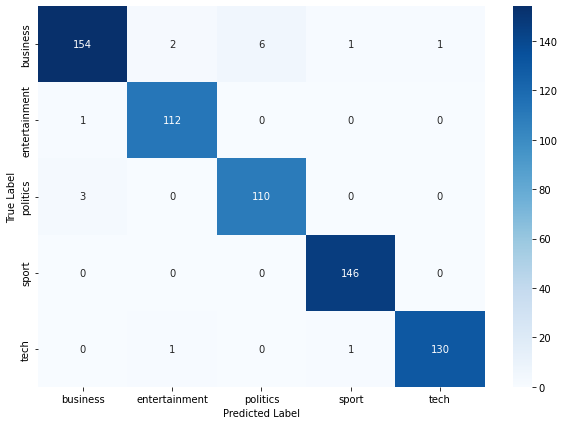

In [63]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index = labelEncoder.inverse_transform([0, 1, 2, 3, 4]),
                  columns = labelEncoder.inverse_transform([0, 1, 2, 3, 4]))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [64]:
x = tfidf_transformer.transform(count_vect.transform(["yukos"]))
labelEncoder.inverse_transform(logisticRegression.predict(x))

array(['business'], dtype=object)